In [1]:
# Importing Libraries

import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

/home/pasindu/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Loading Dataset

leco_all = pd.DataFrame()
root_folder = '/lirneasia/data/lacuna/processed/sm_april_2024_dump'
directory = os.path.join(root_folder)

if os.path.exists(directory):
    files = os.listdir(directory)

    for file_name in files:
        if file_name.endswith('.csv'):
            file_path = os.path.join(root_folder, file_name)
                
            leco_data = pd.read_csv(file_path, low_memory=False)

            leco_all = pd.concat([leco_all, leco_data], ignore_index=False)

else:
    print("path wrong") 

survey_data = pd.read_csv('/lirneasia/data/lacuna/raw/Survey_data/Survey_wave_1_may_29.csv', low_memory=False)

In [3]:
# Data Preprocessing 

leco_all['datetime'] = pd.to_datetime(leco_all['date'] + ' ' + leco_all['time'])
leco_all = leco_all.drop(columns=['date', 'time'])
leco_all = leco_all.sort_values(by=['customerref', 'datetime'])

In [4]:
leco_all['consumption'] = leco_all.groupby('customerref')['importkwh(kwh)'].diff().fillna(0)
leco_all['export'] = leco_all.groupby('customerref')['exportkwh(kwh)'].diff().fillna(0)

leco_all = leco_all[leco_all['consumption'] >= 0]
leco_all = leco_all[leco_all['export'] >= 0]

In [5]:
#Monthly consumption
monthly_consumption = leco_all.set_index('datetime').groupby('customerref')['consumption'].resample('ME').sum().reset_index()
monthly_consumption

,customerref,datetime,consumption
0,101261710,2023-10-31,10.7980
1,101261710,2023-11-30,100.1420
2,101261710,2023-12-31,87.3701
3,101261710,2024-01-31,46.4719
4,101490906,2023-10-31,0.0010
...,...,...,...
5229,708773307,2023-12-31,300.3830
5230,708773307,2024-01-31,1.6120
5231,708793602,2023-10-31,10.9720
5232,708793602,2023-11-30,59.5970


In [6]:
sm = leco_all.drop_duplicates(subset=['customerref'])
merged = pd.merge(sm, survey_data, left_on='customerref', right_on='ACCOUNT_NO', how='inner')
merged = pd.merge(merged, monthly_consumption, left_on='customerref', right_on='customerref', how='inner')
merged

,serial,customerref,timestamp,obis,importkwh(kwh),exportkwh(kwh),importkvarh(kvarh),exportkvarh(kvarh),phaseainstcurrent(a),phasebinstcurrent(a),...,Sawing_Machine_availability,Wood_Chipping_Machine_availability,Concrete_Mixture_Machine_availability,Hair_Cutting_Machine_availability,Generator_Battery_availability,Bouth_availability,Grill_availability,LA_Unique_ID,datetime_y,consumption_y
0,22732556,101261710,1.698520e+12,LP,139.232,0.000,NaN,NaN,0.4121,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10101261710,2023-10-31,10.7980
1,22732556,101261710,1.698520e+12,LP,139.232,0.000,NaN,NaN,0.4121,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10101261710,2023-11-30,100.1420
2,22732556,101261710,1.698520e+12,LP,139.232,0.000,NaN,NaN,0.4121,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10101261710,2023-12-31,87.3701
3,22732556,101261710,1.698520e+12,LP,139.232,0.000,NaN,NaN,0.4121,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10101261710,2024-01-31,46.4719
4,21721253,200134110,1.698550e+12,LP,1574.864,3412.909,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10200134110,2023-10-31,10.8240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1701,22711706,708512409,1.698540e+12,LP,373.652,0.000,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10708512409,2023-11-30,72.7050
1702,22711706,708512409,1.698540e+12,LP,373.652,0.000,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10708512409,2023-12-31,30.6950
1703,22725108,708793602,1.698540e+12,LP,186.489,0.000,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10708793602,2023-10-31,10.9720
1704,22725108,708793602,1.698540e+12,LP,186.489,0.000,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10708793602,2023-11-30,59.5970


In [7]:
merged = merged[merged['datetime_y'] == '2023-11-30'].reset_index()
merged.drop(columns=['index'])

,serial,customerref,timestamp,obis,importkwh(kwh),exportkwh(kwh),importkvarh(kvarh),exportkvarh(kvarh),phaseainstcurrent(a),phasebinstcurrent(a),...,Sawing_Machine_availability,Wood_Chipping_Machine_availability,Concrete_Mixture_Machine_availability,Hair_Cutting_Machine_availability,Generator_Battery_availability,Bouth_availability,Grill_availability,LA_Unique_ID,datetime_y,consumption_y
0,22732556,101261710,1.698520e+12,LP,139.232,0.0000,NaN,NaN,0.4121,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10101261710,2023-11-30,100.1420
1,21721253,200134110,1.698550e+12,LP,1574.864,3412.9090,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10200134110,2023-11-30,135.2330
2,20708313,200700907,1.698530e+12,LP,3508.694,15727.3080,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10200700907,2023-11-30,132.1351
3,20708610,201661801,1.698540e+12,LP,2774.710,7651.4091,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10201661801,2023-11-30,136.9181
4,21721146,201929002,1.698550e+12,LP,2591.833,0.0010,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10201929002,2023-11-30,141.3410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,22730366,707123802,1.698530e+12,LP,33.020,0.0010,NaN,NaN,0.2320,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10707123802,2023-11-30,29.9420
280,23706149,707182311,1.697080e+12,LP,0.000,0.0000,NaN,NaN,0.0270,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10707182311,2023-11-30,245.9330
281,22729794,707436301,1.698530e+12,LP,292.258,0.0000,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10707436301,2023-11-30,144.8160
282,22711706,708512409,1.698540e+12,LP,373.652,0.0000,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10708512409,2023-11-30,72.7050


In [8]:
merged.columns = merged.columns.str.strip().str.lower().str.replace(' ', '_')

In [9]:
'''
consumption_y - Monthly consumption
w1_b_7 - No. of storeys
w1_h_4 - Household expenses for last month
w1_c_1 - No of household memebers
w1_b_8 - floor area of the house
totroom  - Number of rooms
occ - Occupation of the chief wage earner
    occupation_mapping = {
    'Unskilled Worker': 1,
    'Skilled Worker': 2,
    'Clerk / Salesman grades': 3,
    'Supervisor grades': 4,
    'Junior executive / Executive': 5,
    'Middle and Senior executive': 6,
    'Manager / Professional': 7,
    'Small Businessman / Self employed (Non professional)': 8,
    'Boutique owner': 9,
    'Self employed (Professional) - No employees': 10,
    '1-9 Employed': 11,
    '10+ Employed': 12,
    'Agricultural labourer / Worker': 13,
    'Tenant cultivator': 14,
    'Farmer owning - Less than ½ Acre': 15,
    'Farmer owning - ½ - 1 / Acre': 16,
    'Farmer owning - 1 - 2 / Acre': 17,
    'Farmer owning - 2 - 5 / Acre': 18,
    'Farmer owning - Over 5 acres / Landed proprietor': 19
}

edu - Highest level of education attained by the chief wage earner
    education_mapping = {
        'Illiterate': 1,
        'Primary Education': 2,
        'Schooling upto Grade 6 - 9': 3,
        'O/L or A/L pending / Passed': 4,
        'Diploma with O/L or A/L (Non graduate)': 5,
        'Other professional certificates with O/L or A/L / Part qualification (Non graduate)': 6,
        'Graduate /Post-Grads/ Degree level professional qualification': 7
    }

'''

"\nconsumption_y - Monthly consumption\nw1_b_7 - No. of storeys\nw1_h_4 - Household expenses for last month\nw1_c_1 - No of household memebers\nw1_b_8 - floor area of the house\ntotroom  - Number of rooms\nocc - Occupation of the chief wage earner\n    occupation_mapping = {\n    'Unskilled Worker': 1,\n    'Skilled Worker': 2,\n    'Clerk / Salesman grades': 3,\n    'Supervisor grades': 4,\n    'Junior executive / Executive': 5,\n    'Middle and Senior executive': 6,\n    'Manager / Professional': 7,\n    'Small Businessman / Self employed (Non professional)': 8,\n    'Boutique owner': 9,\n    'Self employed (Professional) - No employees': 10,\n    '1-9 Employed': 11,\n    '10+ Employed': 12,\n    'Agricultural labourer / Worker': 13,\n    'Tenant cultivator': 14,\n    'Farmer owning - Less than ½ Acre': 15,\n    'Farmer owning - ½ - 1 / Acre': 16,\n    'Farmer owning - 1 - 2 / Acre': 17,\n    'Farmer owning - 2 - 5 / Acre': 18,\n    'Farmer owning - Over 5 acres / Landed proprietor':

In [10]:
# Handling erroneous data
merged = merged[merged['w1_h_4'] <= 5000000]
merged = merged[merged['w1_b_8'] <= 20000]
merged['w1_b_7'] = merged['w1_b_7'].replace(' ', 0)
merged['w1_b_7'] = merged['w1_b_7'].astype(int)
merged['w1_h_4'] = merged['w1_h_4'].replace(3500000, 350000)

merged['totroomoth'] = merged['totroomoth'].replace(' ', 0)
merged['totroomoth'] = merged['totroomoth'].astype(int)
merged['totroom'] = merged['totroom'] + merged['totroomoth']
merged = merged[merged['totroom'] <= 30]


In [11]:
data = merged[['consumption_y', 'w1_b_7', 'w1_h_4', 'w1_c_1', 'w1_b_8', 'totroom', 'occ', 'edu']]
data = data.reset_index()
data

,index,consumption_y,w1_b_7,w1_h_4,w1_c_1,w1_b_8,totroom,occ,edu
0,0,100.1420,0,75000,6,500.0,7,2,5
1,1,135.2330,3,20000,2,450.0,5,10,3
2,2,132.1351,0,35000,2,400.0,3,9,4
3,3,136.9181,0,200000,4,2100.0,16,7,7
4,4,141.3410,0,60000,5,1400.0,10,2,4
...,...,...,...,...,...,...,...,...,...
227,278,79.7760,0,50000,2,900.0,9,2,5
228,279,29.9420,0,50000,2,100.0,4,4,6
229,281,144.8160,0,75000,4,800.0,7,2,3
230,282,72.7050,0,60000,3,1040.0,8,5,6


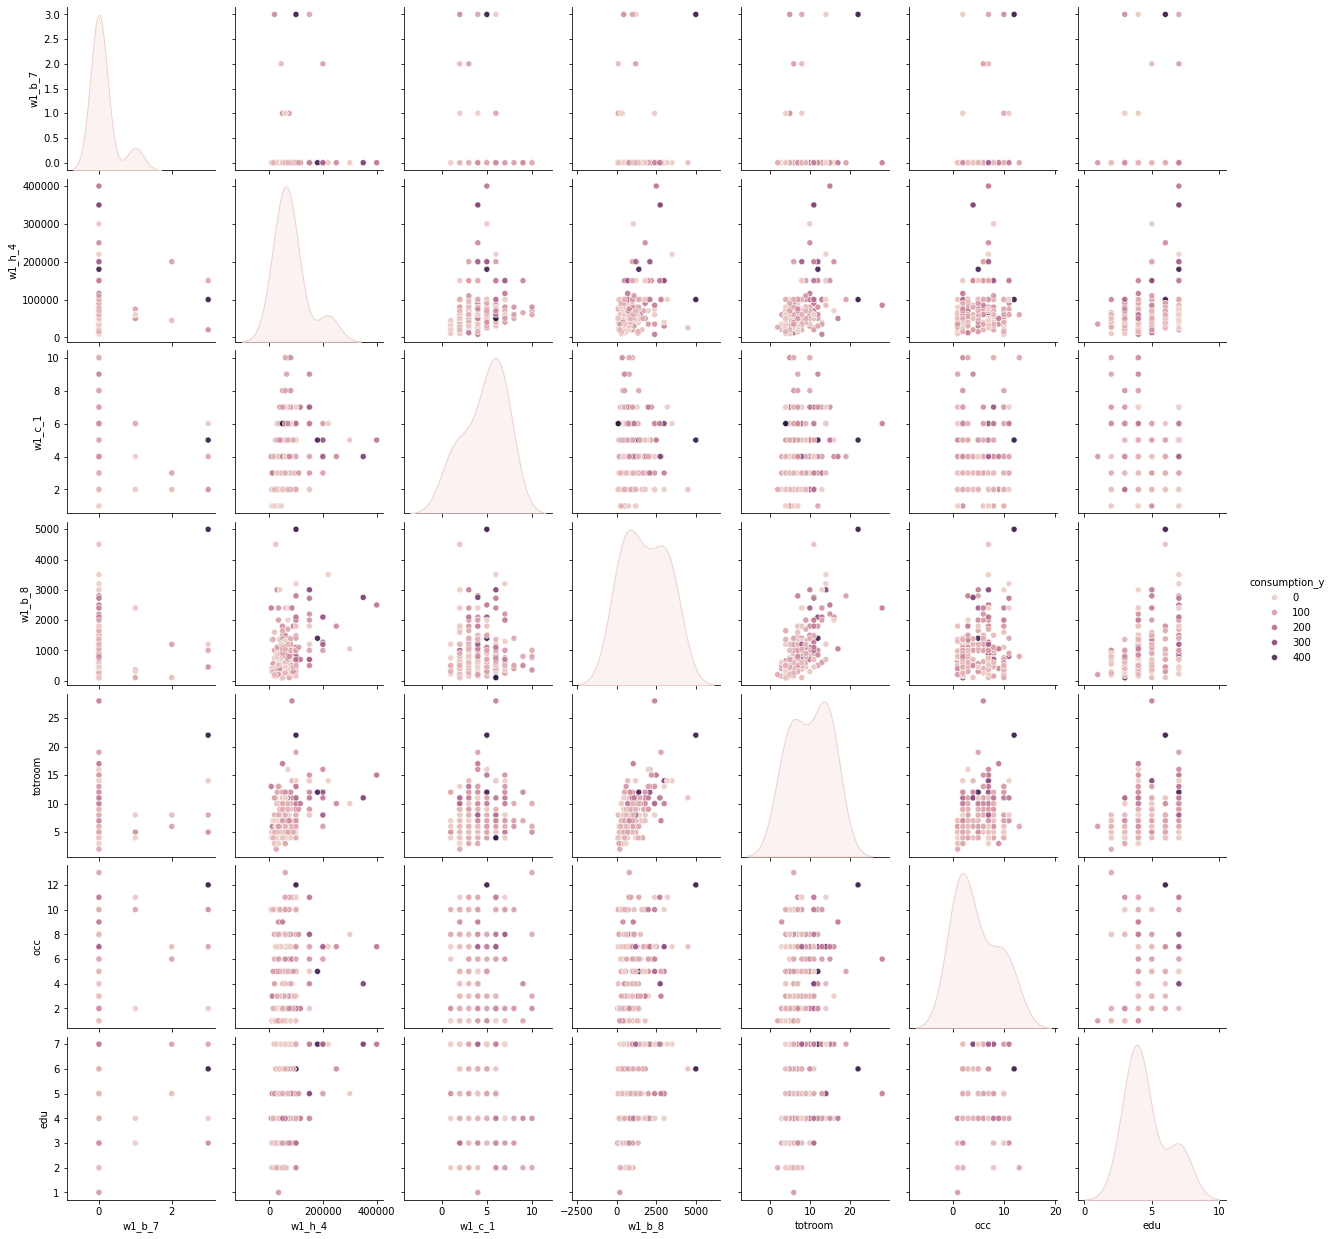

In [12]:
sns.pairplot(data.drop("index", axis=1), hue='consumption_y')

In [13]:
categorical_features = ['occ', 'edu']

numerical_features = ['w1_b_7', 'w1_h_4', 'w1_c_1', 'w1_b_8', 'totroom']

for column in numerical_features:
    merged[column] = pd.to_numeric(merged[column], errors='coerce')

# Handle specific non-numeric entries
merged['w1_b_7'] = merged['w1_b_7'].replace(' ', np.nan)

# Drop rows with NaN values or fill them with mean/median
merged = merged.dropna(subset=numerical_features)

# Forward fill and backward fill missing values
merged = merged.ffill().bfill()

# Additional cleaning step to ensure no empty strings in categorical columns
merged[categorical_features] = merged[categorical_features].replace(' ', np.nan).ffill().bfill()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Transform the data
transformed_features = preprocessor.fit_transform(merged)

# Check the transformed features
print(transformed_features)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1624 stored elements and shape (232, 25)>
  Coords	Values
  (0, 0)	-0.1930228591205457
  (0, 1)	0.08383221630861093
  (0, 2)	1.0118751790313356
  (0, 3)	-0.6082830606165773
  (0, 4)	-0.2046672089461345
  (0, 6)	1.0
  (0, 22)	1.0
  (1, 0)	6.524172638274444
  (1, 1)	-0.9710957622337141
  (1, 2)	-1.1174222498600013
  (1, 3)	-0.6733041028498274
  (1, 4)	-0.7945155626790937
  (1, 14)	1.0
  (1, 20)	1.0
  (2, 0)	-0.1930228591205457
  (2, 1)	-0.6833881317221708
  (2, 2)	-1.1174222498600013
  (2, 3)	-0.7383251450830774
  (2, 4)	-1.384363916412053
  (2, 13)	1.0
  (2, 21)	1.0
  (3, 0)	-0.1930228591205457
  (3, 1)	2.481395803904804
  (3, 2)	-0.05277353541433288
  (3, 3)	1.4723902908474251
  :	:
  (228, 3)	-1.128451398482578
  (228, 4)	-1.0894397395455735
  (228, 8)	1.0
  (228, 23)	1.0
  (229, 0)	-0.1930228591205457
  (229, 1)	0.08383221630861093
  (229, 2)	-0.05277353541433288
  (229, 3)	-0.2181568072170769
  (229, 4)	-0.204667208946134

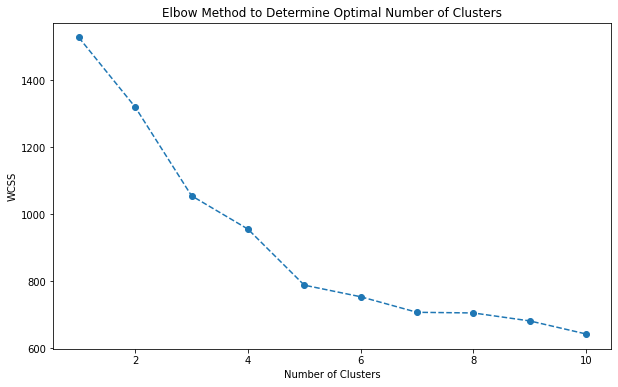

In [14]:
#Elbow Method

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(transformed_features)
    wcss.append(kmeans.inertia_)

# Graph: Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method to Determine Optimal Number of Clusters')
plt.show()

In [15]:
%pip install umap
%pip install umap-learn

Defaulting to user installation because normal site-packages is not writeable
  Using cached umap-0.1.1-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [16]:
%pip install --upgrade umap-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


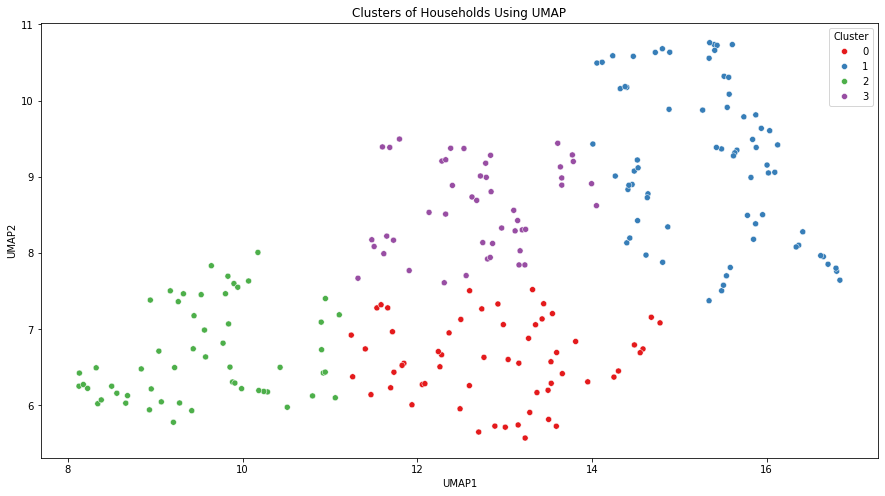

In [26]:
import umap.umap_ as umap

umap_reducer = umap.UMAP()
umap_components = umap_reducer.fit_transform(transformed_features)

# Apply KMeans clustering
kmeans_1 = KMeans(n_clusters=4, random_state=42)
y_kmeans_1 = kmeans_1.fit_predict(umap_components)
merged['Cluster'] = y_kmeans_1

# Create a DataFrame for the UMAP components
df_umap = pd.DataFrame(data=umap_components, columns=['UMAP1', 'UMAP2'])
df_umap['Cluster'] = y_kmeans_1

# Plot the clusters using UMAP components
plt.figure(figsize=(15, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Cluster', data=df_umap, palette='Set1')
plt.title('Clusters of Households Using UMAP')
plt.show()

In [27]:
cluster_summary_1 = merged.groupby('Cluster')[numerical_features].mean().round(2)
cluster_modes = merged.groupby('Cluster')[categorical_features].agg(lambda x: pd.Series.mode(x)[0])
cluster_summary = pd.concat([cluster_summary_1, cluster_modes], axis=1)

cluster_summary

,w1_b_7,w1_h_4,w1_c_1,w1_b_8,totroom,occ,edu
Cluster,,,,,,,
0,0.00,67689.66,5.95,837.67,7.47,2,4
1,0.26,58749.99,3.61,624.71,6.31,2,3
2,0.02,110781.82,4.02,1813.20,11.22,7,7
3,0.00,45468.06,2.66,664.47,5.98,2,4
